In [1]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
# from keras.preprocessing import sequence
# from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
# from keras.layers import Conv2D,Conv1D
# from keras.layers.merge import dot, multiply, add, concatenate
# from keras.layers import Merge
# from keras.layers.core import Lambda,Reshape, Flatten, Dropout
# from keras.layers.pooling import GlobalMaxPooling2D, GlobalMaxPooling1D,MaxPooling1D
# from keras.models import Model
# from keras.backend import transpose,batch_dot,expand_dims
# from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
# from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
# from keras.layers.wrappers import TimeDistributed
# from keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#palette="Greens_d"

In [3]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# soln_filename = '../data/solution.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# doc2vec_model_path='model/doc2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec_sense2vec_all.model'
doc2vec_model_path='model/doc2vec_sense2vec_noun.model'
vocab_path='model/doc2vec_sense2vec_vocab_all.json'
embeddings_path='model/embeddings_sense2vec_all.npz'
full_features_filename = '../data/features_doc2vec_sense2vec_pmi_20170418.csv'

In [4]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


In [5]:
product_df

,product_title,product_uid,product_description,attr_json
0,Simpson Strong-Tie 12-Gauge Angle,100001,"Not only do angles make joints stronger, they ...",{'Bullet01': 'Versatile connector for various ...
1,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,BEHR Premium Textured DECKOVER is an innovativ...,"{'Application Method': 'Brush,Roller,Spray', '..."
2,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,Update your bathroom with the Delta Vero Singl...,"{'Bath Faucet Type': 'Combo Tub and Shower', '..."
3,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,Achieving delicious results is almost effortle...,"{'Appliance Type': 'Over the Range Microwave',..."
4,Lithonia Lighting Quantum 2-Light Black LED Em...,100007,The Quantum Adjustable 2-Light LED Black Emerg...,"{'Battery Power Type': 'Ni-Cad', 'Battery Size..."
5,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,100009,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,"{'Application': 'Door & Window', 'Bullet01': '..."
6,Valley View Industries Metal Stakes (4-Pack),100010,Valley View Industries Metal Stakes (4-Pack) a...,"{'Attachable': 'No', 'Bullet01': 'Can be used ..."
7,Toro Personal Pace Recycler 22 in. Variable Sp...,100011,Recycler 22 in. Personal Pace Variable Speed S...,"{'Assembled Depth (in.)': '59 in', 'Assembled ..."
8,Hampton Bay Caramel Simple Weave Bamboo Rollup...,100012,The 96 in. wide Caramel Simple Weave Rollup Ba...,"{'Actual Blind/Shade Width (In.)': '96', 'Arch..."
9,InSinkErator SinkTop Switch Single Outlet for ...,100013,The InSinkErator SinkTop Switch Single Outlet ...,"{'Bullet01': 'Kit includes satin nickel, chrom..."


In [6]:
train_query_df,product_df, attribute_df = HomeDepotFeature().getFeature(train_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii,brand")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 6 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
search_term      74067 non-null object
relevance        74067 non-null float64
relevance_int    74067 non-null int64
product_idx      74067 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB
train_query_df final column:
 None


In [7]:
test_query_df,_, _ = HomeDepotFeature().getFeature(test_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.04 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
id             166693 non-null int64
product_uid    166693 non-null int64
search_term    166693 non-null object
product_idx    166693 non-null object
dtypes: int64(2), object(2)
memory usage: 5.1+ MB
train_query_df final column:
 None


In [8]:
product_df

,product_title,product_uid,product_description,attr_json,product_brand
0,Simpson Strong Tie 12 Gauge Angle,100001,Not only do angles make joints stronger they a...,'Bullet01' 'Versatile connector for various 90...,Simpson Strong-Tie
1,BEHR Premium Textured deck over 1 gal SC 141 T...,100002,BEHR Premium Textured deck over is an innovati...,'Application Method' 'Brush Roller Spray' 'Ass...,BEHR Premium Textured DeckOver
2,Delta verso 1 Handle Shower Only Faucet Trim K...,100005,Update your bathroom with the Delta verso Sing...,'Bath Faucet Type' 'Combo Tub and Shower' 'Bui...,Delta
3,Whirlpool 1 9 cu. ft. Over the Range Convectio...,100006,Achieving delicious results is almost effortle...,'Appliance Type' 'Over the Range Microwave' 'A...,Whirlpool
4,lithograph Lighting Quantum 2 Light Black LED ...,100007,The Quantum Adjustable 2 Light LED Black Emerg...,'Battery Power Type' 'Ni Cad' 'Battery Size' '...,Lithonia Lighting
5,House of Fara 3 4 in. x 3 in. x 8 ft. MDF Flut...,100009,Get the House of Fara 3 4 in. x 3 in. x 8 ft. ...,'Application' 'Door Window' 'Bullet01' 'Made o...,House of Fara
6,Valley View Industries Metal Stakes 4 Pack,100010,Valley View Industries Metal Stakes 4 Pack are...,'Attachable' 'No' 'Bullet01' 'Can be used with...,Valley View Industries
7,Toro Personal Pace re cycler 22 in. Variable S...,100011,re cycler 22 in. Personal Pace Variable Speed ...,'Assembled Depth in. ' '59 in' 'Assembled Heig...,Toro
8,Hampton Bay Caramel Simple Weave Bamboo roll u...,100012,The 96 in. wide Caramel Simple Weave roll up B...,'Actual Blind Shade Width In. ' '96' 'Arched' ...,Hampton Bay
9,insinuator sink top Switch Single Outlet for i...,100013,The insinuator sink top Switch Single Outlet f...,'Bullet01' 'Kit includes satin nickel chrome a...,InSinkErator


In [9]:
# ## no attribute
product_df['content'] = product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str) 
    
    


In [10]:
product_df['content_brand'] = product_df['product_brand']+ ". " + \
                        product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str)

In [11]:
# attribute
product_df['content_attr'] = product_df['product_title'].map(str) + ". " + \
                            product_df['attr_json'].map(str)
# product_df['product_brand']+ ". " + \
#                        
#                         product_df['product_description'].map(str)  + ". " + \
                        

# resample

In [12]:
#resample remove the low classes
resampled_train_query_df = train_query_df[train_query_df.relevance_int == 0]
min_samples=len(resampled_train_query_df)
for i in range(1,13):
    print(i)
    tmp_df = train_query_df[train_query_df.relevance_int == i]
    if len(tmp_df) > min_samples:
        tmp_df = tmp_df.ix[np.random.choice(tmp_df.index,min_samples)]
        resampled_train_query_df=pd.concat([resampled_train_query_df,tmp_df])

    else:
        print("removing {} as too few values {}".format(i,len(tmp_df)))
        
ori_train_query_df=train_query_df        
train_query_df=resampled_train_query_df

1
removing 1 as too few values 4
2
3
removing 3 as too few values 5
4
5
removing 5 as too few values 9
6
7
removing 7 as too few values 11
8
9
removing 9 as too few values 19
10
11
removing 11 as too few values 11
12


In [13]:
#don't sample
#train_query_df=ori_train_query_df


In [14]:
# #### merge test and train queries for training
# orig_train_query_df = train_query_df
# train_query_df = pd.concat([train_query_df,test_query_df])


In [15]:
len(train_query_df)

14735

# end resample

In [16]:
feature_df = reader.getBasicDataFrame(full_features_filename)

In [17]:
feature_df_filtered = feature_df.merge(train_query_df, on=['id'])

In [18]:
feature_df_filtered

,Unnamed: 0,id,product_idx_x,product_uid_x,relevance_x,relevance_int_x,search_term_x,color_exist,color1hot_almond,color1hot_aluminum,...,sense2vec_uidfact_keeptag_attr_simscore,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,pmi,product_uid_y,search_term_y,relevance_y,relevance_int_y,product_idx_y
0,17,69,"Int64Index([11], dtype='int64')",100017,1.00,0.0,door guard,0,0,0,...,0.005866,0.0,0.0,0.000000,23.993237,100017,door guards,1.00,0,"Int64Index([11], dtype='int64')"
1,21,88,"Int64Index([12], dtype='int64')",100019,1.33,2.0,1x1 rail decor wood,0,0,0,...,0.112187,2.0,1.0,0.050000,35.086178,100019,1x1 rail decorative wood,1.33,2,"Int64Index([12], dtype='int64')"
2,27,113,"Int64Index([13], dtype='int64')",100021,2.00,6.0,lawn sprinkler,0,0,0,...,0.002815,4.0,2.0,0.058824,23.674522,100021,lawn sprinkler,2.00,6,"Int64Index([13], dtype='int64')"
3,33,125,"Int64Index([15], dtype='int64')",100023,2.00,6.0,concret pond,1,0,0,...,0.093856,4.0,1.0,0.032520,32.871089,100023,concrete for ponds,2.00,6,"Int64Index([15], dtype='int64')"
4,35,136,"Int64Index([16], dtype='int64')",100026,2.00,6.0,belgium block paver,0,0,0,...,-0.001058,2.0,2.0,0.042553,31.955344,100026,Belgium block pavers,2.00,6,"Int64Index([16], dtype='int64')"
5,39,149,"Int64Index([18], dtype='int64')",100028,2.67,10.0,balconi privaci screen,0,0,0,...,0.000325,0.0,0.0,0.000000,31.371042,100028,balcony privacy screen,2.67,10,"Int64Index([18], dtype='int64')"
6,49,178,"Int64Index([21], dtype='int64')",100033,1.00,0.0,kitchen cabinet finish,0,0,0,...,0.073279,1.0,1.0,0.007353,32.697649,100033,kitchen cabinet finishes,1.00,0,"Int64Index([21], dtype='int64')"
7,53,186,"Int64Index([21], dtype='int64')",100033,3.00,12.0,shelv metal,0,0,0,...,0.107900,0.0,0.0,0.000000,24.351340,100033,Shelves Metal,3.00,12,"Int64Index([21], dtype='int64')"
8,56,195,"Int64Index([22], dtype='int64')",100034,1.00,0.0,mortar tool,0,0,0,...,-0.003684,0.0,0.0,0.000000,23.882041,100034,mortar tools,1.00,0,"Int64Index([22], dtype='int64')"
9,57,201,"Int64Index([23], dtype='int64')",100036,2.33,8.0,12 boltless bracket,0,0,0,...,0.039583,4.0,2.0,0.117647,32.057339,100036,12 boltless bracket,2.33,8,"Int64Index([23], dtype='int64')"


In [19]:
cols=feature_df_filtered.columns

In [20]:
for c in cols:
    print("'{}',".format(c))

'Unnamed: 0',
'id',
'product_idx_x',
'product_uid_x',
'relevance_x',
'relevance_int_x',
'search_term_x',
'color_exist',
'color1hot_almond',
'color1hot_aluminum',
'color1hot_beige',
'color1hot_biscuit',
'color1hot_bisque',
'color1hot_black',
'color1hot_blue',
'color1hot_bone',
'color1hot_brass',
'color1hot_bronze',
'color1hot_brown',
'color1hot_cedar',
'color1hot_charcoal',
'color1hot_cherry',
'color1hot_chestnut',
'color1hot_chocolate',
'color1hot_chrome',
'color1hot_clear',
'color1hot_color',
'color1hot_concrete',
'color1hot_copper',
'color1hot_cream',
'color1hot_daylight',
'color1hot_espresso',
'color1hot_gold',
'color1hot_gray',
'color1hot_green',
'color1hot_grey',
'color1hot_ivory',
'color1hot_java',
'color1hot_linen',
'color1hot_mahogany',
'color1hot_metallic',
'color1hot_mocha',
'color1hot_multi',
'color1hot_natural',
'color1hot_nickel',
'color1hot_oak',
'color1hot_orange',
'color1hot_pewter',
'color1hot_pink',
'color1hot_platinum',
'color1hot_primed',
'color1hot_purple',
'color1

In [21]:
# feat_cols= ['color_exist',
# # 'color1hot_almond',
# # 'color1hot_aluminum',
# # 'color1hot_beige',
# # 'color1hot_biscuit',
# # 'color1hot_bisque',
# # 'color1hot_black',
# # 'color1hot_blue',
# # 'color1hot_bone',
# # 'color1hot_brass',
# # 'color1hot_bronze',
# # 'color1hot_brown',
# # 'color1hot_cedar',
# # 'color1hot_charcoal',
# # 'color1hot_cherry',
# # 'color1hot_chestnut',
# # 'color1hot_chocolate',
# # 'color1hot_chrome',
# # 'color1hot_clear',
# # 'color1hot_color',
# # 'color1hot_concrete',
# # 'color1hot_copper',
# # 'color1hot_cream',
# # 'color1hot_daylight',
# # 'color1hot_espresso',
# # 'color1hot_gold',
# # 'color1hot_gray',
# # 'color1hot_green',
# # 'color1hot_grey',
# # 'color1hot_ivory',
# # 'color1hot_java',
# # 'color1hot_linen',
# # 'color1hot_mahogany',
# # 'color1hot_metallic',
# # 'color1hot_mocha',
# # 'color1hot_multi',
# # 'color1hot_natural',
# # 'color1hot_nickel',
# # 'color1hot_oak',
# # 'color1hot_orange',
# # 'color1hot_pewter',
# # 'color1hot_pink',
# # 'color1hot_platinum',
# # 'color1hot_primed',
# # 'color1hot_purple',
# # 'color1hot_red',
# # 'color1hot_sand',
# # 'color1hot_silver',
# # 'color1hot_slate',
# # 'color1hot_stainless',
# # 'color1hot_steel',
# # 'color1hot_tan',
# # 'color1hot_taupe',
# # 'color1hot_teal',
# # 'color1hot_unfinished',
# # 'color1hot_walnut',
# # 'color1hot_white',
# # 'color1hot_wood',
# # 'color1hot_yellow',
# 'brand_exist',
# 'wm_product_description',
# 'wm_product_title',
# 'wm_product_brand',
# 'wm_attr_json',
# #'Word2VecQueryExpansion',
# 'tfidf_product_title',
# 'tfidf_product_brand',
# 'tfidf_product_description',
# 'tfidf_attr_json',
# 'tfidf_expanded_product_title',
# 'tfidf_expanded_product_brand',
# 'tfidf_expanded_product_description',
# 'tfidf_expanded_attr_json',
# 'doc2vec_product_title',
# 'doc2vec_product_brand',
# 'doc2vec_product_description',
# 'doc2vec_attr_json',
# 'doc2vec_expanded_product_title',
# 'doc2vec_expanded_product_brand',
# 'doc2vec_expanded_product_description',
# 'doc2vec_expanded_attr_json',
# 'bm25',
# 'bm25expandedquery',
# 'bm25description',
# 'bm25title',
# 'bm25brand',
# 'len_product_title',
# 'len_product_description',
# 'len_brand',
# 'len_search_term',
# 'sense2vec_all_simscore',
# 'sense2vec_keeptag_simscore',
# 'sense2vec_uidfact_all_simscore',
# 'sense2vec_uidfact_keeptag_simscore',
# 'product_uid_threshold',
# 'sense2vec_all_attr_simscore',
# 'sense2vec_keeptag_attr_simscore',
# 'sense2vec_uidfact_all_attr_simscore',
# 'sense2vec_uidfact_keeptag_attr_simscore',
# 'noun_overlap_counts',
# 'noun_uniq_overlap_counts',
# 'noun_overlap_ratios' ]

In [22]:
feature_df_filtered.drop('id', axis=1, inplace=True)
feature_df_filtered.drop('search_term_x', axis=1, inplace=True)
feature_df_filtered.drop('search_term_y', axis=1, inplace=True)
feature_df_filtered.drop('product_uid_x', axis=1, inplace=True)
feature_df_filtered.drop('product_uid_y', axis=1, inplace=True)
feature_df_filtered.drop('relevance_int_x', axis=1, inplace=True)
feature_df_filtered.drop('relevance_int_y', axis=1, inplace=True)
feature_df_filtered.drop('product_idx_x', axis=1, inplace=True)
feature_df_filtered.drop('product_idx_y', axis=1, inplace=True)
feature_df_filtered.drop('Word2VecQueryExpansion', axis=1, inplace=True)


==== Unnamed: 0


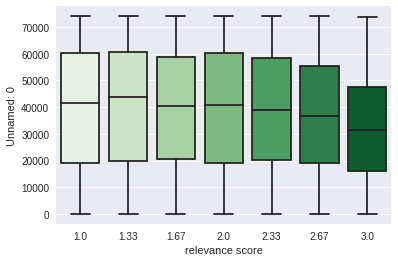

==== relevance_x


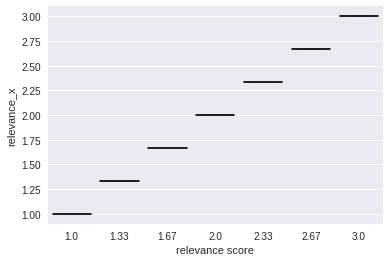

==== color_exist
binary
==== color1hot_almond
binary
==== color1hot_aluminum
binary
==== color1hot_beige
binary
==== color1hot_biscuit
binary
==== color1hot_bisque
binary
==== color1hot_black
binary
==== color1hot_blue
binary
==== color1hot_bone
binary
==== color1hot_brass
binary
==== color1hot_bronze
binary
==== color1hot_brown
binary
==== color1hot_cedar
binary
==== color1hot_charcoal
binary
==== color1hot_cherry
binary
==== color1hot_chestnut
pointless
==== color1hot_chocolate
pointless
==== color1hot_chrome
binary
==== color1hot_clear
binary
==== color1hot_color
binary
==== color1hot_concrete
binary
==== color1hot_copper
binary
==== color1hot_cream
binary
==== color1hot_daylight
binary
==== color1hot_espresso
binary
==== color1hot_gold
binary
==== color1hot_gray
binary
==== color1hot_green
binary
==== color1hot_grey
binary
==== color1hot_ivory
binary
==== color1hot_java
binary
==== color1hot_linen
binary
==== color1hot_mahogany
binary
==== color1hot_metallic
binary
==== color1hot_m

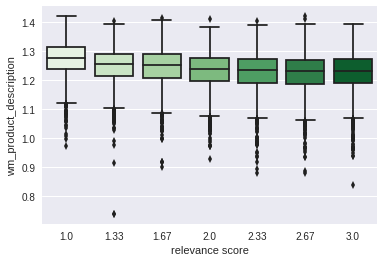

==== wm_product_title


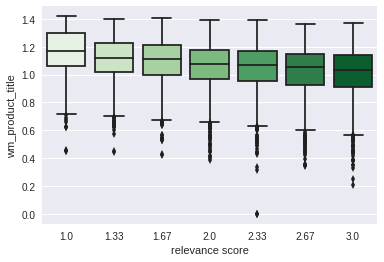

==== wm_product_brand


/home/ongmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4234: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/ongmin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2058: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/ongmin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2065: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/ongmin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2074: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


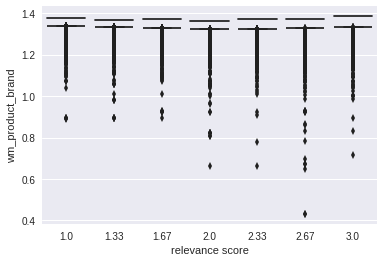

==== wm_attr_json


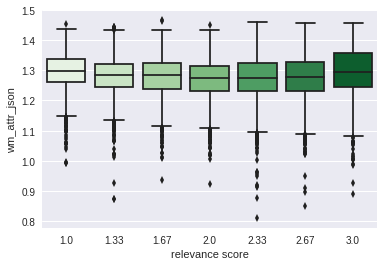

==== tfidf_product_title


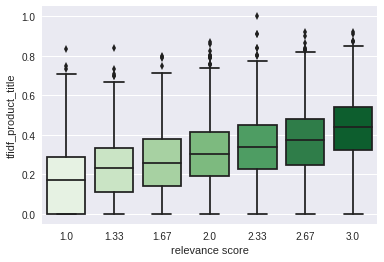

==== tfidf_product_brand


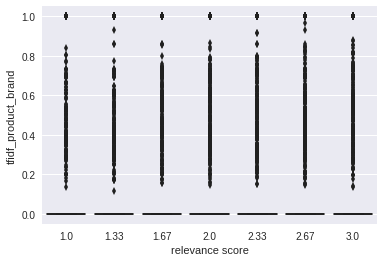

==== tfidf_product_description


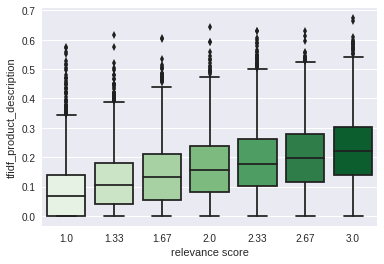

==== tfidf_attr_json


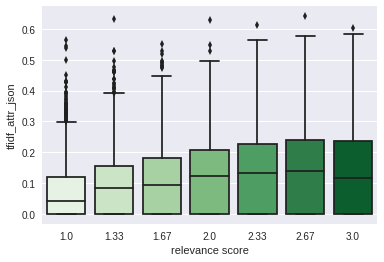

==== tfidf_expanded_product_title


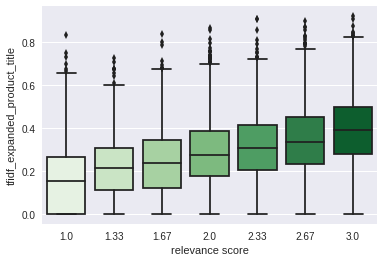

==== tfidf_expanded_product_brand


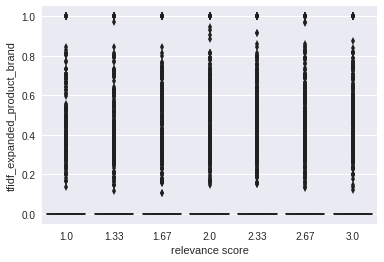

==== tfidf_expanded_product_description


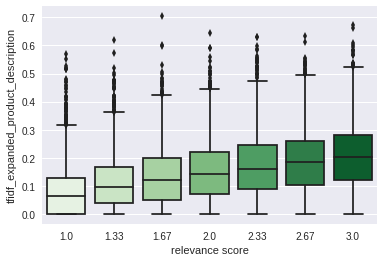

==== tfidf_expanded_attr_json


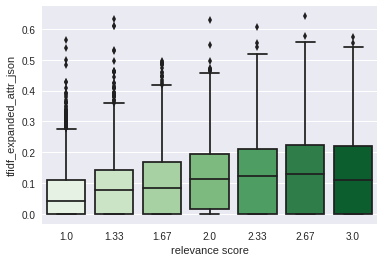

==== doc2vec_product_title


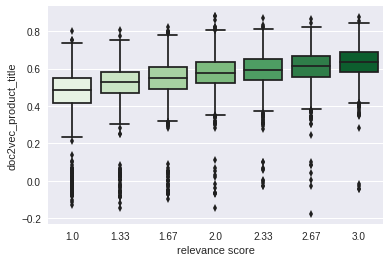

==== doc2vec_product_brand


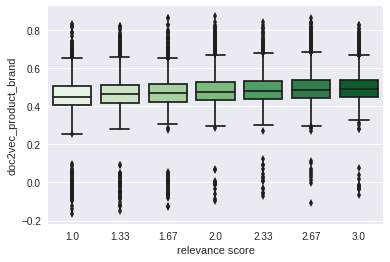

==== doc2vec_product_description


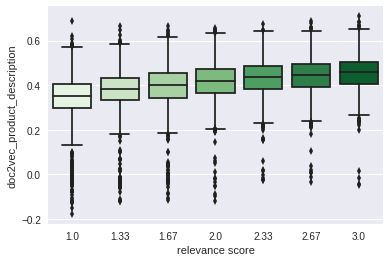

==== doc2vec_attr_json


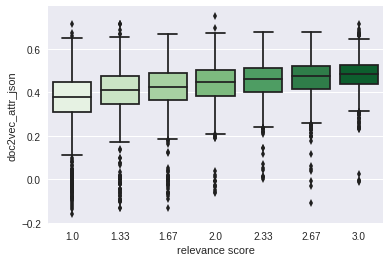

==== doc2vec_expanded_product_title


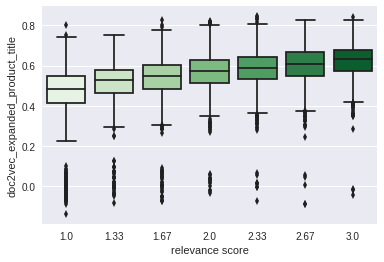

==== doc2vec_expanded_product_brand


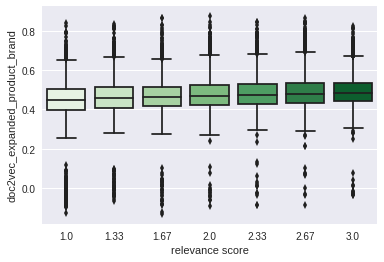

==== doc2vec_expanded_product_description


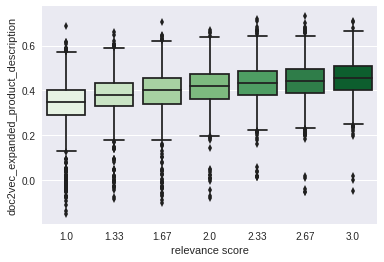

==== doc2vec_expanded_attr_json


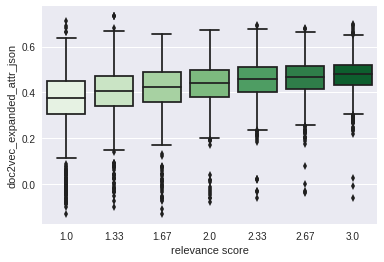

==== bm25


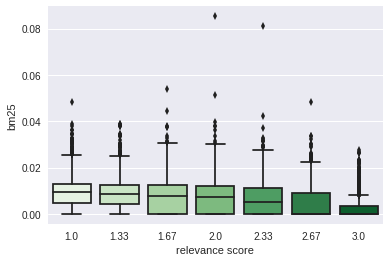

==== bm25expandedquery


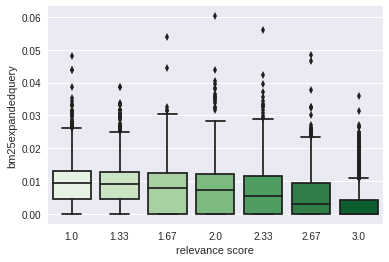

==== bm25description


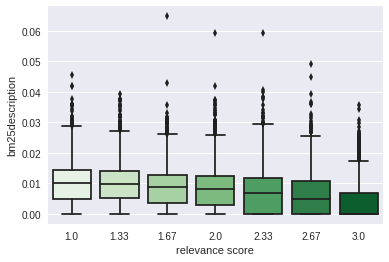

==== bm25title


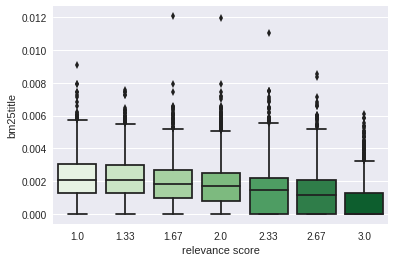

==== bm25brand


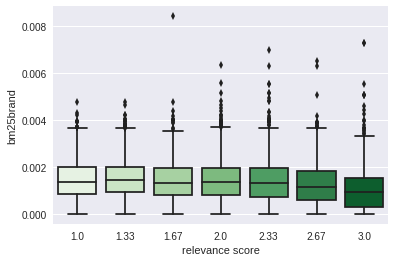

==== len_product_title


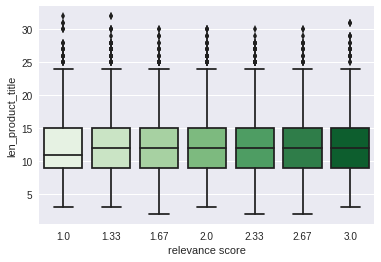

==== len_product_description


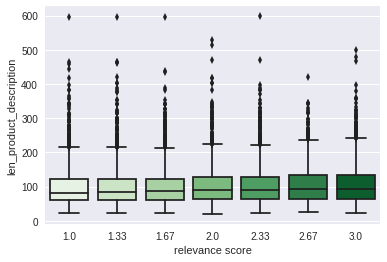

==== len_brand


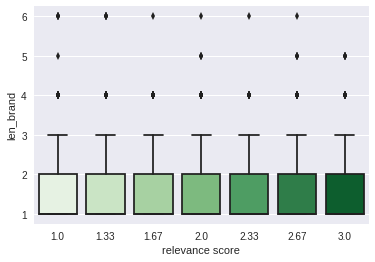

==== len_search_term


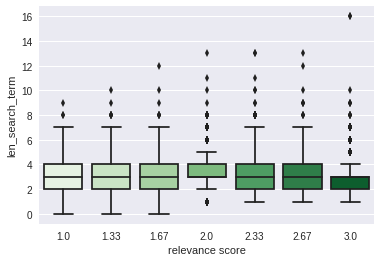

==== sense2vec_all_simscore


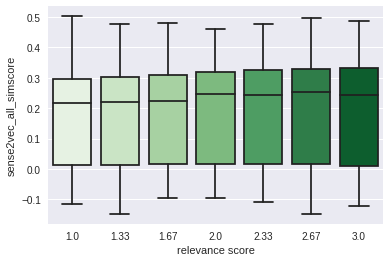

==== sense2vec_keeptag_simscore


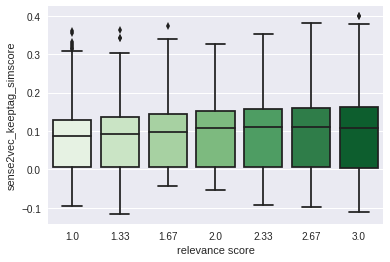

==== sense2vec_uidfact_all_simscore


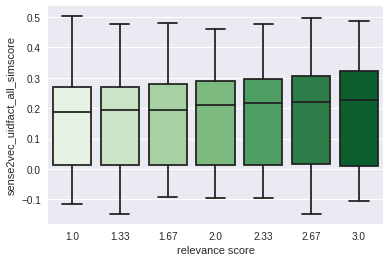

==== sense2vec_uidfact_keeptag_simscore


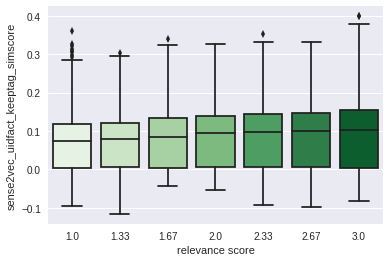

==== product_uid_threshold
binary
==== sense2vec_all_attr_simscore


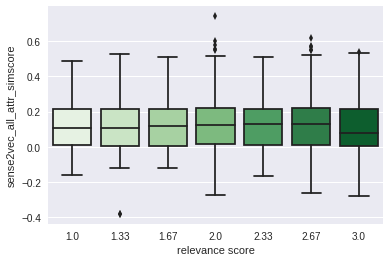

==== sense2vec_keeptag_attr_simscore


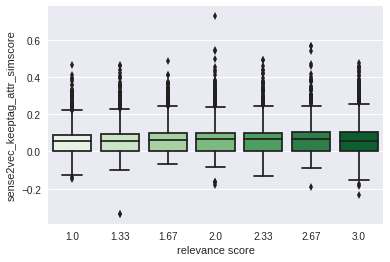

==== sense2vec_uidfact_all_attr_simscore


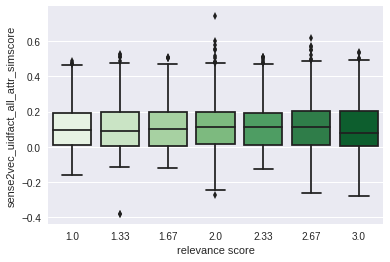

==== sense2vec_uidfact_keeptag_attr_simscore


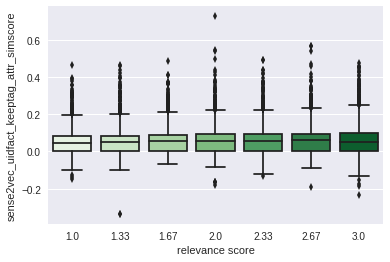

==== noun_overlap_counts


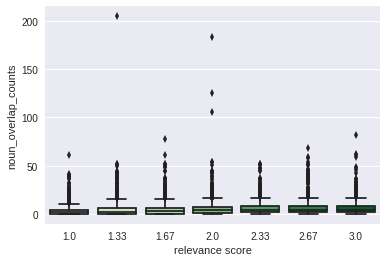

==== noun_uniq_overlap_counts


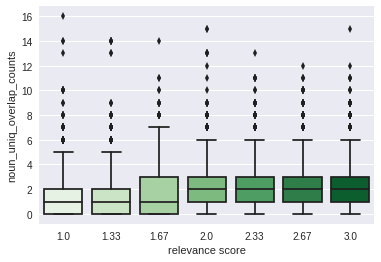

==== noun_overlap_ratios


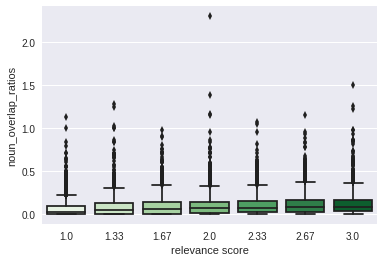

==== pmi


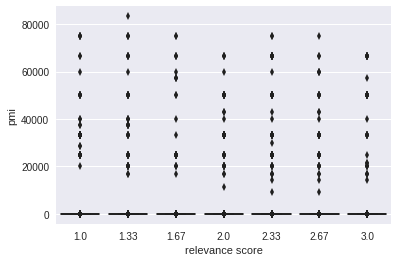

==== relevance_y


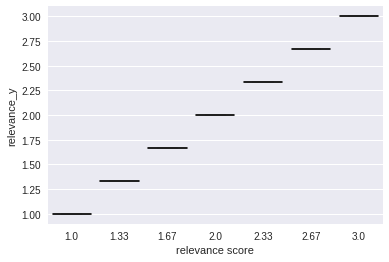

In [23]:
#https://www.quora.com/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together
def rescale_bounded_cont_feat(x,xmax,xmin):
    x_new = (2*x-xmax-xmin)/(xmax-xmin)
    return x_new

def rescale_cont_feat(x,xmean,xstd):
    x_new = (x-xmean)/xstd
    return x_new

feature_rescale_df = feature_df_filtered.copy()
#feat_cols = ['sense2vec_keeptag_simscore']
for feat_col in feature_rescale_df.columns:
    print("==== {}".format(feat_col))
    if len(feature_rescale_df[feat_col].value_counts()) == 1:
        print('pointless')
    elif len(feature_rescale_df[feat_col].value_counts()) == 2:
        print('binary')
    else:
#         feature_rescale_df[feat_col]=feature_rescale_df[feat_col].apply(rescale_bounded_cont_feat, \
#                               args=(feature_rescale_df[feat_col].max(),feature_rescale_df[feat_col].min()))
        fig = plt.gcf()
        #fig.set_size_inches(8,15)
        #sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
        #sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
        sns.boxplot(feature_rescale_df['relevance_y'],feature_rescale_df[feat_col],palette="Greens")
        plt.xlabel('relevance score')
        plt.show()

In [24]:
feature_rescale_df

,Unnamed: 0,relevance_x,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,color1hot_biscuit,color1hot_bisque,color1hot_black,color1hot_blue,...,product_uid_threshold,sense2vec_all_attr_simscore,sense2vec_keeptag_attr_simscore,sense2vec_uidfact_all_attr_simscore,sense2vec_uidfact_keeptag_attr_simscore,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,pmi,relevance_y
0,17,1.00,0,0,0,0,0,0,0,0,...,1,0.036218,0.005866,0.036218,0.005866,0.0,0.0,0.000000,23.993237,1.00
1,21,1.33,0,0,0,0,0,0,0,0,...,1,0.306085,0.112187,0.306085,0.112187,2.0,1.0,0.050000,35.086178,1.33
2,27,2.00,0,0,0,0,0,0,0,0,...,1,0.014942,0.002815,0.014942,0.002815,4.0,2.0,0.058824,23.674522,2.00
3,33,2.00,1,0,0,0,0,0,0,0,...,1,0.255277,0.093856,0.255277,0.093856,4.0,1.0,0.032520,32.871089,2.00
4,35,2.00,0,0,0,0,0,0,0,0,...,1,-0.047185,-0.001058,-0.047185,-0.001058,2.0,2.0,0.042553,31.955344,2.00
5,39,2.67,0,0,0,0,0,0,0,0,...,1,0.018632,0.000325,0.018632,0.000325,0.0,0.0,0.000000,31.371042,2.67
6,49,1.00,0,0,0,0,0,0,0,0,...,1,0.186006,0.073279,0.186006,0.073279,1.0,1.0,0.007353,32.697649,1.00
7,53,3.00,0,0,0,0,0,0,0,0,...,1,0.270283,0.107900,0.270283,0.107900,0.0,0.0,0.000000,24.351340,3.00
8,56,1.00,0,0,0,0,0,0,0,0,...,1,0.036578,-0.003684,0.036578,-0.003684,0.0,0.0,0.000000,23.882041,1.00
9,57,2.33,0,0,0,0,0,0,0,0,...,1,0.095507,0.039583,0.095507,0.039583,4.0,2.0,0.117647,32.057339,2.33


In [25]:
# fig = plt.gcf()
# fig.set_size_inches(8,15)
# #sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
# #sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
# sns.boxplot(relevance_scores,avg_uidfact_all_similarity_scores)
# #palette="Greens_d"
# #sns.despine()

In [26]:
# fig = plt.gcf()
# fig.set_size_inches(8,15)
# #sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
# #sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
# sns.boxplot(relevance_scores,avg_uidfact_keep_tag_similarity_scores)

# #sns.despine()

In [27]:
# fig = plt.gcf()
# fig.set_size_inches(8,15)
# #sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
# #sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
# sns.boxplot(relevance_scores,avg_all_similarity_scores)

# #sns.despine()

In [28]:
# fig = plt.gcf()
# fig.set_size_inches(8,15)
# #sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
# #sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
# sns.boxplot(relevance_scores,avg_keep_tag_similarity_scores)

# #sns.despine()